# SCDAA Group Assignment 2024

Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch

## Exercise 1

### Exercise 1.1

In [3]:
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, t, S_flat, H, M, D_inv, C):
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid, atol=1e-10, rtol=1e-10):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(
            self.riccati_ode, 
            [self.T, time_grid[0]], 
            S0_flat, 
            t_eval=time_grid[::-1], 
            args=(self.H, self.M, D_inv, self.C), 
            atol=atol, 
            rtol=rtol,
            method='Radau'  # This is a common choice for stiff ODEs
        )
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))[:, :, ::-1]
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution


    def compute_value_function(self, t_tensor, x_tensor):
        """
        Computes the control problem value v(t, x) for a batch of space x using the solution of S
        and includes the integral term.
        """
       
        batch_size = x_tensor.shape[0]
        
        # Convert all relevant data to PyTorch tensors
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        dt = solution_time[1] - solution_time[0]
        
        sigma_squared = sigma_tensor @ sigma_tensor.T
        
        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)
        
        # Initialize v
        v = torch.zeros(batch_size, 1, dtype=torch.float32)
        
        # Pre-compute trace values for each S_tensor slice, to be used in batch operations
        trace_values = torch.einsum('ij,jik->k', sigma_squared, S_tensor)
        
        # Compute the cumulative sum of trace values for integral computation
        cum_integral = torch.cumsum(trace_values, dim=0) * dt
        
        # Adjust cum_integral by subtracting the cumulative sum up to each t, to effectively start from each t
        adjusted_integral = cum_integral[-1] - cum_integral
        
        for i in range(batch_size):
            idx = time_indexes[i]
            
            # Calculate the integral from t to T
            integral_term = adjusted_integral[idx]
            
            # Calculate v for each batch
            S_at_t = S_tensor[:, :, idx]
            v[i] = x_tensor[i].T @ S_at_t @ x_tensor[i] + integral_term

        return v

    def compute_markov_control(self, t_tensor, x_tensor):
        """
        Computes the Markov control function for a batch of x at time t using S(t).
        """
        batch_size = x_tensor.shape[0]

        # Find the index corresponding to the nearest time point in the time grid
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)

        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)

        # Initialize control
        control = torch.zeros(batch_size, 2, dtype=torch.float32)

        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float32)
        M_T = torch.tensor(self.M.T, dtype=torch.float32)

        # Compute the control using S(t)
        for i in range(batch_size):
            S_t = S_tensor[:, :, time_indexes[i]]
            control[i] = - D_inv @ M_T @ S_t @ x_tensor[i].T  # Make sure the dimensions are correct

        return control

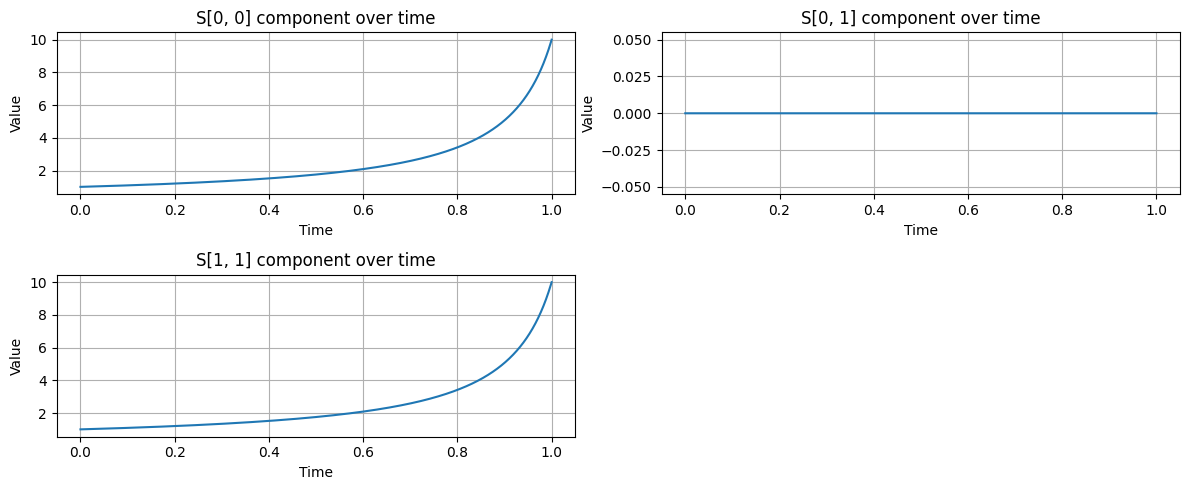

In [4]:
# Example matrices (to be replaced with actual problem data)
H = np.array([[1, 0], [0, 1]]) * 0.1
M = np.array([[1, 0], [0, 1]])
sigma = np.array([[1, 0], [0, 1]]) * 0.001
C = np.array([[0, 0], [0, 0]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]]) * 10
T = 1

# Time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)

# Example of using the class (with random time and space inputs for demonstration)
torch.manual_seed(0)  # For reproducibility
random_t = torch.rand(5) * T
random_x = torch.rand(5, 2) * 6 - 3  # Uniformly sampled from [-3, 3]

# Initialize the LQR problem
lqr_problem = LQRProblem(H, M, C, D, R, sigma, T)
S_solution, time_solution = lqr_problem.solve_riccati_ode(time_grid)

plt.figure(figsize=(12, 5))

# Plot for S[0, 0]
plt.subplot(2, 2, 1)
plt.plot(time_solution, S_solution[0, 0, :], label='S[0, 0]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[0, 0] component over time')
plt.grid(True)

# Plot for S[0, 1]
plt.subplot(2, 2, 2)
plt.plot(time_solution, S_solution[0, 1, :], label='S[0, 1]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[0, 1] component over time')
plt.grid(True)

# Since S is symmetric, S[1, 0] should be the same as S[0, 1]
# Plot for S[1, 1]
plt.subplot(2, 2, 3)
plt.plot(time_solution, S_solution[1, 1, :], label='S[1, 1]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('S[1, 1] component over time')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

/tmp/ipykernel_1471/224025782.py:87: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  v[i] = x_tensor[i].T @ S_at_t @ x_tensor[i] + integral_term


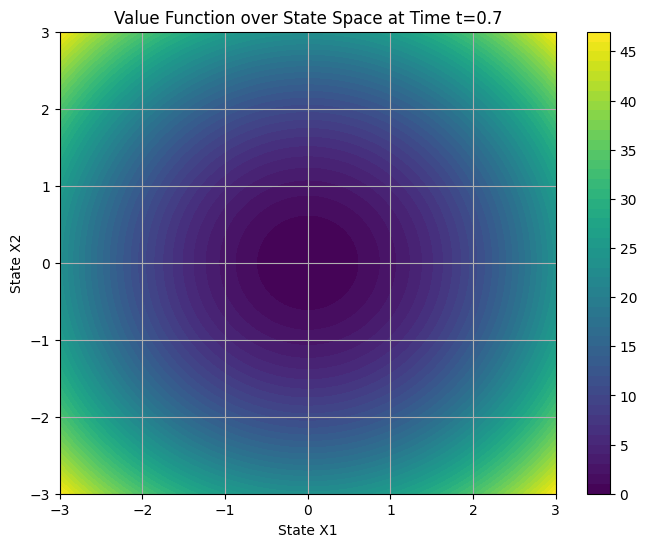

In [5]:
# Solve the Riccati ODE using the given time grid
lqr_problem.solve_riccati_ode(time_grid)

# Assuming T and lqr_problem are already defined
t = 14*T/20
T_tensor = torch.tensor([t], dtype=torch.float32)  # Convert T to a tensor

# Generate a grid of state space points to compute the value function
state_space_grid = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(state_space_grid, state_space_grid)
value_function_values = np.zeros_like(X1)

# Compute the value function for each point in the state space grid at time T
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = torch.tensor([[X1[i, j], X2[i, j]]], dtype=torch.float32)  # Shape: [1, 2]
        val = lqr_problem.compute_value_function(T_tensor, x).item()  # Use T_tensor
        value_function_values[i, j] = val

# Plotting the value function
plt.figure(figsize=(8, 6))
cp = plt.contourf(X1, X2, value_function_values, cmap='viridis', levels=50)
plt.colorbar(cp)
plt.xlabel('State X1')
plt.ylabel('State X2')
plt.title(f'Value Function over State Space at Time t={t}')
plt.grid(True)
plt.show()

In [5]:
random_t = (torch.rand(5) * T)
print(random_t.shape)
random_x = torch.rand(5, 2) * 6 - 3 
value = lqr_problem.compute_value_function(random_t, random_x)
control = lqr_problem.compute_markov_control(random_t, random_x)

print(value)
print(control)

torch.Size([5])
tensor([[13.4468],
        [13.9893],
        [ 1.1456],
        [17.6510],
        [ 5.4871]])
tensor([[-1.9818, -4.5309],
        [ 1.5933, -5.7933],
        [ 1.6557, -1.0869],
        [-3.1703,  3.2480],
        [ 2.5009,  1.0057]])


### Exercise 1.2

In [6]:
def simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples):
    dt = (lqr_problem.T - t0) / N_steps
    costs_all_paths = []
    
    
    # Convert system matrices to tensors, including D_inv_MT
    H_tensor = torch.tensor(lqr_problem.H, dtype=torch.float32)
    M_tensor = torch.tensor(lqr_problem.M, dtype=torch.float32)
    sigma_tensor = torch.tensor(lqr_problem.sigma, dtype=torch.float32)
    C_tensor = torch.tensor(lqr_problem.C, dtype=torch.float32)
    D_tensor = torch.tensor(lqr_problem.D, dtype=torch.float32)

    for _ in range(num_samples): 
        cost_path = 0.0
        
        x_T = x0.clone().detach().view(1, 2)
        for step in range(N_steps):
            t = t0 + step * dt
            step_opt_control_T = lqr_problem.compute_markov_control(t, x_T)
            step_opt_control = step_opt_control_T.T
            x = x_T.T
            drift = H_tensor @ x + M_tensor @ step_opt_control
            dW = (torch.randn(2, dtype=torch.float32) * torch.sqrt(dt)).unsqueeze(1)
            x += drift * dt + sigma_tensor @ dW
            x_T = x.T
            cost_path += (x.T @ C_tensor @ x + step_opt_control.T @ D_tensor @ step_opt_control) * dt

        cost_path += x.T @ torch.tensor(lqr_problem.R, dtype=torch.float32) @ x

        costs_all_paths.append(cost_path.item())

    MC_value = np.average(costs_all_paths)

    return MC_value

5.190909385681152
[0.010614495277405211, 0.0012489891052247515, 0.0007219219207765804, 0.0006808519363401544, 0.0009686183929442649, 0.0004952335357666371]


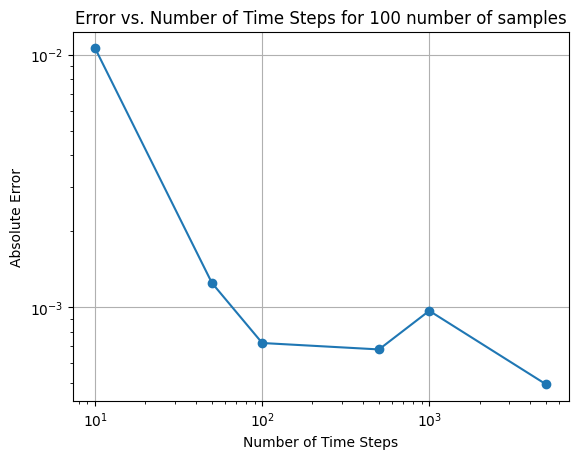

In [7]:
# Example usage:
t0 = torch.tensor([0.7], dtype=torch.float32)
x0 = torch.tensor([1.0, 1.0])  # Initial state

# Number of time steps and Monte Carlo samples for the simulation
N_steps_list = [10, 50, 100, 500, 1000, 5000]
num_samples = 100

# Generate a time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)  # Fine time grid for better accuracy
lqr_problem.solve_riccati_ode(time_grid)

# Compute the theoretical value at the initial state x0
analytical_opt_value = lqr_problem.compute_value_function(t0, x0.unsqueeze(0)).item()

# Run the simulation and compute errors for different numbers of time steps
errors = []
for N_steps in N_steps_list:
    MC_opt_value = simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples)
    error = abs(MC_opt_value - analytical_opt_value)
    errors.append(error)

# Plot the error vs. number of time steps
plt.loglog(N_steps_list, errors, marker='o')
plt.xlabel('Number of Time Steps')
plt.ylabel('Absolute Error')
plt.title(f'Error vs. Number of Time Steps for {num_samples} number of samples')
plt.grid()
plt.show()


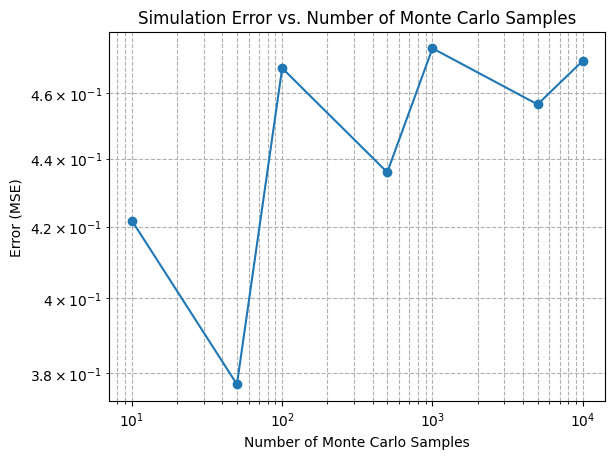

In [ ]:
# Step 1: Fix a large number of time steps
N_steps_fixed = 5000

# Step 2: Use the previously defined simulate_dynamics function, no changes needed here

# Step 3: Vary the number of Monte Carlo samples and compute errors
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000]
errors = []

iteration = 0
for num_samples in num_samples_list:
    MC_opt_value = simulate_dynamics(lqr_problem, t0, x0, N_steps_fixed, num_samples)
    error = abs(MC_opt_value - analytical_opt_value)
    errors.append(error)
    print('iteration:', iteration)
    iteration+=1

# Step 4: Plot the error on a log-log plot
plt.loglog(num_samples_list, errors, marker='o', linestyle='-')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('Error (MSE)')
plt.title('Simulation Error vs. Number of Monte Carlo Samples')
plt.grid(True, which="both", ls="--")
plt.show()


## Exercise 2

### Exercise 2.1

In [7]:
import torch.nn as nn
import torch.optim as optim

class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

Epoch [100/500], Loss: 23.6450
Epoch [200/500], Loss: 4.6037
Epoch [300/500], Loss: 2.4075
Epoch [400/500], Loss: 0.7784
Epoch [500/500], Loss: 0.3016


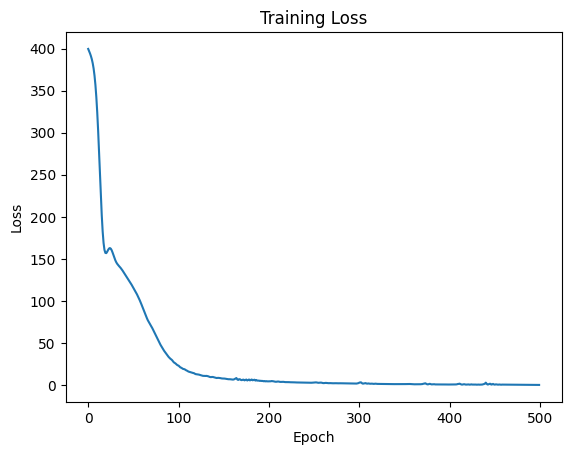

In [8]:
# Instantiate the network
# Instantiate the network for DGM
net_dgm = Net_DGM(dim_x=2, dim_S=100).float()

# Generate training data
num_samples = 1000  # Number of samples for training data
t_samples = (torch.rand(num_samples) * lqr_problem.T).float()  # Sampling t uniformly in [0, T]
x_samples = (torch.rand(num_samples, 2) * 6 - 3).float()  # Sampling x uniformly in [-3, 3] x [-3, 3]
#print(t_samples.shape)
#print(x_samples.shape)
value_function_data = lqr_problem.compute_value_function(t_samples, x_samples).float()

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(net_dgm.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 500  # Number of epochs for training
training_losses = []

# Training loop
for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass to get output/logits
    x_reshaped = x_samples.reshape(-1, 2)
    outputs = net_dgm.forward(t_samples.unsqueeze(1), x_reshaped)

    # Calculate loss
    loss = criterion(outputs, value_function_data)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Record and print the training loss
    training_losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, plot the training loss
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Exercise 2.2

In [9]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).float())
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).float()

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).float()

Epoch [100/500], Control Loss: 6.8433
Epoch [200/500], Control Loss: 4.3922
Epoch [300/500], Control Loss: 2.6025
Epoch [400/500], Control Loss: 1.8526
Epoch [500/500], Control Loss: 1.1936


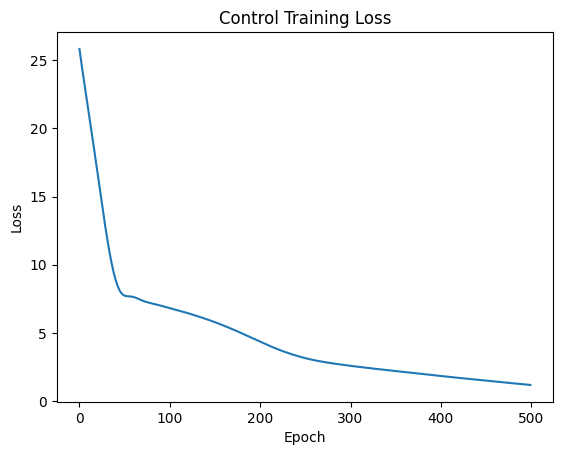

In [10]:
# Generate training data for Markov control
control_targets = lqr_problem.compute_markov_control(t_samples, x_samples).float()

# Instantiate the neural network for Markov control
control_network = FFN(sizes = [1 + 2, 100, 100, 2]).float()

# Loss function and optimizer for the control network
control_criterion = nn.MSELoss()  # Mean squared error loss
control_optimizer = optim.Adam(control_network.parameters(), lr=0.001)  # Adam optimizer

control_training_losses = []

# Training loop for the control network
for epoch in range(num_epochs):
    # Zero the parameter gradients
    control_optimizer.zero_grad()

    x_reshaped = x_samples.reshape(-1, 2)

    # Prepare the inputs to the network (concatenating t and x)
    control_inputs = torch.cat((t_samples.unsqueeze(1), x_reshaped), dim=1)

    # Forward pass to get output/logits
    control_outputs = control_network.forward(control_inputs)

    # Calculate loss
    control_loss = control_criterion(control_outputs, control_targets)

    # Backward pass and optimize
    control_loss.backward()
    control_optimizer.step()

    # Record and print the training loss
    control_training_losses.append(control_loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Control Loss: {control_loss.item():.4f}')

# After training, plot the training loss for the control network
plt.plot(control_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Control Training Loss')
plt.show()


## Exercise 3

### Exercise 3.1

In [11]:
# Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         return self.fc3(x)
    
class Net(nn.Module):
    def __init__(self, n_layer, n_hidden, dim):
        super(Net, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 1)

    
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))

        out = self.output_layer(o)

        return out
    
    def act(self, x):
        return x * torch.sigmoid(x)    

# Instantiate the neural network
input_size = 3  # Because we have t, x1, and x2
hidden_size = 100  # Given in the exercise instructions
output_size = 3  # Scalar output for u(t, x)
net = Net(input_size, hidden_size, output_size)

class LinearPDE(nn.Module):
    def __init__(self, net, T, H, M, C, D, R, sigma, alpha):
        super(LinearPDE, self).__init__()
        self.net = net
        self.T = T
        # Convert all numpy arrays to torch tensors
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.alpha = alpha
        

    def forward(self, t, x):
        # Check the shape of t and x
        #print("Shape of t:", t.shape)  # Expected to be [64, 1]
        #print("Shape of x:", x.shape)  # Expected to be [64, 2]

        # Concatenate t and x along the second dimension (dim=1)
        # t is expanded to match the batch size of x
        tx = torch.cat((t, x), dim=1)
        
        # Check the shape of the concatenated input
        #print("Shape of concatenated input:", tx.shape)  # Expected to be [64, 3]

        u = self.net(tx)
        return u

    def pde_residual(self, t, x):
        u = self.forward(t, x)
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

        # Assuming that u_x is computed and has shape [batch_size, state_dim] where state_dim=2
        # Initialize a list to store the second-order derivatives for each dimension
        u_xx_list = []

        # Compute the second derivatives (Hessian) with respect to each dimension of x
        for i in range(x.shape[1]):
            # Compute the gradient of u_x with respect to x for the i-th dimension across the batch
            u_x_grads = torch.autograd.grad(outputs=u_x[:, i].sum(), inputs=x, create_graph=True, retain_graph=True)[0]
            # Append the computed gradients to the list
            u_xx_list.append(u_x_grads.unsqueeze(-1))

        # Concatenate the second-order derivatives along the last dimension to form the Hessian matrix
        u_xx = torch.cat(u_xx_list, dim=-1)

        # Now u_xx has shape [batch_size, state_dim, state_dim]

        # Assuming u_xx has shape [batch_size, 2, 2] and sigma has shape [2, 2]
        sigma_matrix = self.sigma @ self.sigma.T  # Compute sigma sigma^T
        term1 = 0.5 * torch.einsum('bij,jk,bik->bi', u_xx, sigma_matrix, u_xx)
        
        # term2 calculation
        Hx = torch.matmul(self.H, x.unsqueeze(-1)).squeeze(-1)  # shape: [64, 2]
        Malpha = torch.matmul(self.M, self.alpha.unsqueeze(-1)).squeeze(-1)  # shape: [64, 2]
        term2 = (u_x * (Hx + Malpha)).sum(dim=1, keepdim=True)
        
        # term3 calculation
        #term3 = (x.unsqueeze(1) * torch.matmul(self.C, x.unsqueeze(-1))).sum(dim=2).sum(dim=1, keepdim=True) + torch.dot(self.alpha, torch.matmul(self.D, self.alpha))
        # term3 calculation
        Cx = torch.matmul(self.C, x.unsqueeze(-1)).squeeze(-1)  # Ensure Cx is two-dimensional
        term3 = (x * Cx).sum(dim=1, keepdim=True)  # Element-wise multiplication and sum

        alpha_D_alpha = torch.dot(self.alpha, torch.matmul(self.D, self.alpha.unsqueeze(-1)).squeeze(-1))
        term3 += alpha_D_alpha  # Add the scalar result to each element in term3

        # f calculation
        f = term3

        # Inside the pde_residual function before the error line
        # print("u_t shape:", u_t.shape)
        #print("u_x shape:", u_x.shape)
        # print("u_xx_component1 shape:", u_xx_component1.shape)
        # print("u_xx_component2 shape:", u_xx_component2.shape)
        #print("u_xx shape:", u_xx.shape)
        #print("sigma @ sigma.T shape:", (sigma @ sigma.T).shape)

        # assert u_t.shape == (x.shape[0], 1), "u_t shape mismatch"
        # assert u_x.shape == (x.shape[0], 2), "u_x shape mismatch"
        # assert u_xx.shape == (x.shape[0], 2, 2), "u_xx shape mismatch"

        # print("term1 shape:", term1.shape)
        # print("term2 shape:", term2.shape)
        # print("term3 shape:", term3.shape)
        # print("f shape:", f.shape)
        # assert term1.shape == (x.shape[0], 1), "term1 shape mismatch"
        # assert term2.shape == (x.shape[0], 1), "term2 shape mismatch"
        # assert term3.shape == (x.shape[0], 1), "term3 shape mismatch"
        # assert f.shape == (x.shape[0], 1), "f shape mismatch"
        
        pde_res = u_t + term1 + term2 + term3 - f
        # print("pde_res shape:", pde_res.shape)
        return pde_res

    def boundary_condition(self, x):
        # Expand t to have the same batch size as x, and retain a second dimension of 1
        t_expanded = torch.full((x.size(0), 1), self.T, device=x.device, requires_grad=True)
        
        # Concatenate t and x for input to the neural network
        tx = torch.cat((t_expanded, x), dim=1)
        
        # Forward pass through the neural network to compute u(T, x)
        u_T = self.net(tx)
        
        # Calculate the target boundary condition value
        target = (x @ self.R @ x.T).sum(1, keepdim=True)
        
        # Calculate the squared difference for the boundary condition
        bc_res = (u_T - target) ** 2
        return bc_res

    def loss(self, t_batch, x_batch):
        # Compute the PDE residual (differential error) at the provided batch points
        pde_loss = torch.mean(self.pde_residual(t_batch, x_batch) ** 2)

        # For boundary conditions, we'll assume t_batch includes the terminal time T
        # Hence, we filter out the points where time is T
        terminal_mask = (t_batch == self.T)
        x_terminal = x_batch[terminal_mask.squeeze(), :]
        t_terminal = t_batch[terminal_mask]

        # Compute boundary condition (terminal error) only at the final time T
        if t_terminal.numel() > 0:  # Check if there are any terminal points
            boundary_loss = torch.mean(self.boundary_condition(t_terminal, x_terminal))
        else:
            boundary_loss = 0

        # Combine the PDE residual and boundary condition losses
        total_loss = pde_loss + boundary_loss
        return total_loss


Epoch 0, Loss: 2.9415970857371576e-05
Epoch 100, Loss: 3.3830351853225693e-09
Epoch 200, Loss: 1.7613647207426197e-09
Epoch 300, Loss: 1.0354271884338573e-09
Epoch 400, Loss: 6.921622164313135e-10
Epoch 500, Loss: 4.513196483202364e-10
Epoch 600, Loss: 3.559133543440396e-10
Epoch 700, Loss: 2.8347932334860104e-10
Epoch 800, Loss: 2.2322339809921488e-10
Epoch 900, Loss: 2.1608181910437452e-10


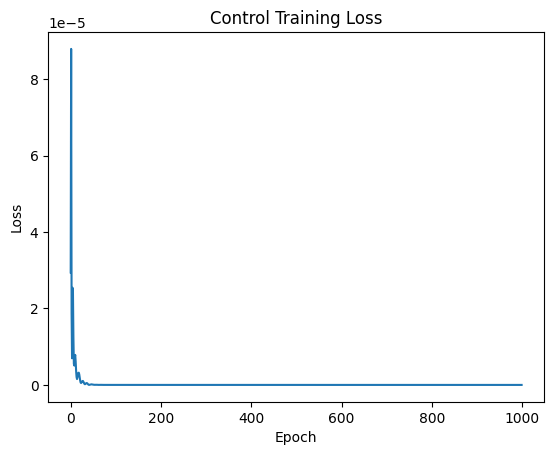

In [12]:
# Training setup
T = 1.0  # End of the time interval
epochs = 1000  # Number of training epochs
learning_rate = 0.001  # Learning rate for optimization
batch_size = 1000  # Size of the batch for each training step

# Assuming H, M, C, D, R, sigma are defined
# For the sake of this example, dummy definitions are provided
H = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 0.1
M = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32)
C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
D = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32)
R = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 10
sigma = torch.tensor([[1.0, 0], [0, 1.0]], dtype=torch.float32) * 0.001
alpha = torch.tensor([1.0, 1.0], dtype=torch.float32)

model = LinearPDE(net, T, H, M, C, D, R, sigma, alpha)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


training_losses = []

# Training loop
for epoch in range(epochs):
    # Sample random points in the time-space domain
    t_batch = torch.rand(batch_size, 1, requires_grad=True) * T
    x_batch = (torch.rand(batch_size, 2, requires_grad=True) * 6 - 3)  # Uniformly in [-3, 3]

    # Set gradients to zero
    optimizer.zero_grad()
    
    # Compute loss
    loss = model.loss(t_batch, x_batch)
    
    # Perform backpropagation
    loss.backward()
    
    # Update the network weights
    optimizer.step()

    # Record and print the training loss
    training_losses.append(loss.item())

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



# After training, plot the training loss for the control network
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Control Training Loss')
plt.show()

In [13]:
def simulate_dynamics_w_constant_control(alpha, t0, x0, N_steps, num_samples, sigma, H, M, C, D, R):
    dt = (T - t0) / N_steps
    costs_all_paths = []

    for _ in range(num_samples): 
        cost_path = 0.0
        # Ensure x is a two-dimensional column vector for state variables
        x = x0.clone().detach().view(2, 1)  # x0 needs to be reshaped to [2, 1] if it isn't already
        for step in range(N_steps):
            drift = (H @ x + M @ alpha.view(2, 1)) * dt
            dW = torch.randn(2, 1, dtype=torch.float32) * torch.sqrt(dt)
            x = x + drift + sigma @ dW  # Ensure this addition involves tensors of shape [2, 1]
            cost_path += (x.T @ C @ x + alpha.view(1, 2) @ D @ alpha.view(2, 1)) * dt

        cost_path += x.T @ R @ x  # The final cost

        costs_all_paths.append(cost_path.item())

    MC_value = np.mean(costs_all_paths)  # Use np.mean instead of np.average for consistency

    return MC_value

In [14]:

# Make sure to define 'lqr_problem' and 'model' appropriately before using this function.
# 'model' is your trained neural network.

trained_network = model  # This is your trained model

# Assume alpha, H, M, C, D, R, sigma are defined as tensors with appropriate shapes
alpha = torch.tensor([1.0, 1.0])  # Example constant alpha vector
T = lqr_problem.T  # Total time
N_steps = 100  # Number of steps in the simulation
num_samples = 1000  # Number of Monte Carlo samples
x0 = torch.tensor([1.0, 1.0], dtype=torch.float32).view(2, 1)  # Initial condition of the system

# Run the simulation
t0 = torch.tensor([0.0], dtype=torch.float32)  # Start time
MC_value = simulate_dynamics_w_constant_control(alpha, t0, x0, N_steps, num_samples, sigma, H, M, C, D, R)

# Assume 'model' is your trained model
# Sampling points for comparison
t_val = torch.rand(num_samples, 1) * T
x_val = torch.rand(num_samples, 2) * 6 - 3  # Sampled uniformly between [-3, 3]

# Get the solution from the neural network for each time and space sample
with torch.no_grad():
    # Ensure that you split the concatenated tensor back into t and x before passing them to the network
    tx_combined = torch.cat((t_val, x_val), dim=1)
    # Split the tensor into t and x components
    t_nn = tx_combined[:, :1]  # Assuming the first column is time
    x_nn = tx_combined[:, 1:]  # The rest are spatial dimensions
    # Pass the separated tensors to the trained network
    neural_net_solution = trained_network(t_nn, x_nn).view(-1).numpy()

# Generate Monte Carlo solutions for the same sampled points
mc_solutions = np.array([simulate_dynamics_w_constant_control(alpha, t_val[i], x_val[i], N_steps, 1, sigma, H, M, C, D, R)
                         for i in range(num_samples)])

# Compute error at each sample point
error = np.abs(neural_net_solution - mc_solutions)

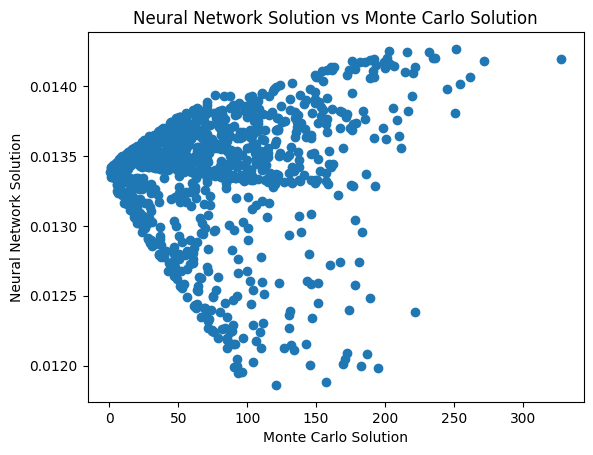

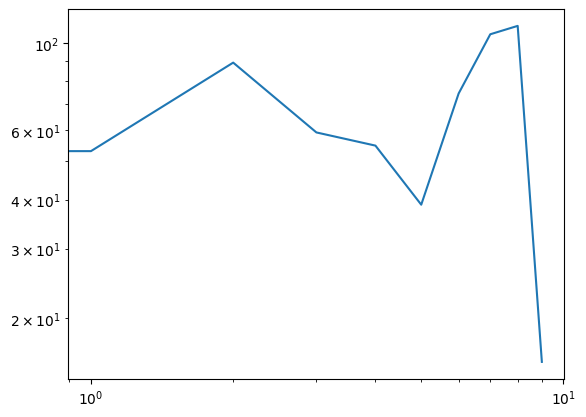

In [15]:
error_plt = error[::100]
# Visualization of neural network solution vs Monte Carlo solution
plt.figure()
plt.scatter(mc_solutions, neural_net_solution)
plt.xlabel('Monte Carlo Solution')
plt.ylabel('Neural Network Solution')
plt.title('Neural Network Solution vs Monte Carlo Solution')
plt.show()

plt.loglog(error_plt)
plt.show()

----

## Exercise 4